In [ ]:
import json
import re
import os
from os.path import join

import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import log_loss
from skopt.space import Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

import cfbd
from cfbd.rest import ApiException

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

with open("../config.json") as f:
    configuration = cfbd.Configuration(
        access_token = json.load(f)["CFBD_API_KEY"]
    )

In [6]:
YEARS = range(1930, 2025)
DATA_DIR = "../data"

In [7]:
def convert_to_snake_case(cols):
    cols_new = []
    for c in cols:
        s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', c)
        cols_new.append(re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower())
    return cols_new

In [8]:
# Load games data
all_dfs = []
id_cols = ['id', 'season', 'week', 'season_type', 'completed', 'neutral_site', 'venue_id']
home_cols = ['home_id', 'home_team', 'home_conference', 'home_division', 'home_points', 'home_pregame_elo']
away_cols = ['away_id', 'away_team', 'away_conference', 'away_division', 'away_points', 'away_pregame_elo']

games_dir = join(DATA_DIR, "games")
if not os.path.exists(games_dir):
    os.makedirs(games_dir)


for year in YEARS:
    file_path = join(games_dir, f"{year}.parquet")
    if os.path.exists(file_path):
        print(f"Reading {file_path} from cached data")
        df_tmp = pd.read_parquet(file_path)
    else:
        print(f"Fetching {year} games data from CFBD API")
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.GamesApi(api_client)
            data = api_instance.get_games(year=year)
        df_tmp = pd.DataFrame([val.to_dict() for val in data])
        df_tmp.columns = convert_to_snake_case(df_tmp.columns)
        df_tmp = df_tmp[id_cols + [
                            'home_id','home_team','home_conference','home_classification','home_points','home_pregame_elo',
                            'away_id','away_team','away_conference','away_classification','away_points','away_pregame_elo']]
        df_tmp['season_type'] = df_tmp['season_type'].apply(lambda x: x.value)
        df_tmp = df_tmp.assign(
            home_division=df_tmp['home_classification'].apply(lambda x: x.value if x is not None else None),
            away_division=df_tmp['away_classification'].apply(lambda x: x.value if x is not None else None)
        ).drop(columns=['home_classification','away_classification'])
        df_tmp = df_tmp[id_cols + home_cols + away_cols]
        df_tmp.to_parquet(file_path)
    all_dfs.append(df_tmp)
del df_tmp

df_games = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
df_games.head()

Fetching 1930 games data from CFBD API
Fetching 1931 games data from CFBD API
Fetching 1932 games data from CFBD API
Fetching 1933 games data from CFBD API
Fetching 1934 games data from CFBD API
Fetching 1935 games data from CFBD API
Fetching 1936 games data from CFBD API
Fetching 1937 games data from CFBD API
Fetching 1938 games data from CFBD API
Fetching 1939 games data from CFBD API
Fetching 1940 games data from CFBD API
Fetching 1941 games data from CFBD API
Fetching 1942 games data from CFBD API
Fetching 1943 games data from CFBD API
Fetching 1944 games data from CFBD API
Fetching 1945 games data from CFBD API
Fetching 1946 games data from CFBD API
Fetching 1947 games data from CFBD API
Fetching 1948 games data from CFBD API
Fetching 1949 games data from CFBD API
Fetching 1950 games data from CFBD API
Fetching 1951 games data from CFBD API
Fetching 1952 games data from CFBD API
Fetching 1953 games data from CFBD API
Fetching 1954 games data from CFBD API
Fetching 1955 games data 

/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_99199/708651682.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_games = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)


,id,season,week,season_type,completed,neutral_site,venue_id,home_id,home_team,home_conference,home_division,home_points,home_pregame_elo,away_id,away_team,away_conference,away_division,away_points,away_pregame_elo
0,16829,1930,1,regular,True,False,NaN,147,Montana State,Rocky Mountain,fbs,44.0,NaN,1000702,Centerville (Butte),None,None,0.0,NaN
1,16830,1930,1,regular,True,False,NaN,2628,TCU,Southwest,fbs,40.0,NaN,2837,East Texas A&M,None,None,0.0,NaN
2,16831,1930,1,regular,True,False,NaN,2483,Oregon,Pacific,fbs,20.0,NaN,1000650,Pacific (Oregon),None,None,0.0,NaN
3,16832,1930,2,regular,True,False,NaN,2184,Duquesne,None,None,0.0,NaN,277,West Virginia,FBS Independents,fbs,7.0,NaN
4,16841,1930,2,regular,True,False,NaN,2553,Sewanee,Southern,fbs,25.0,NaN,55,Jacksonville State,None,None,0.0,NaN


In [22]:
# Directory for caching
teams_dir = join(DATA_DIR, "teams")
if not os.path.exists(teams_dir):
    os.makedirs(teams_dir)

# Load team data with caching
all_teams = []
for year in YEARS:
    file_path = join(teams_dir, f"{year}.parquet")
    if os.path.exists(file_path):
        print(f"Reading {file_path} from cached data")
        df_tmp = pd.read_parquet(file_path)
    else:
        print(f"Fetching {year} team data from CFBD API")
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.TeamsApi(api_client)
            teams = api_instance.get_teams(year=year)
        df_tmp = pd.DataFrame([team.to_dict() for team in teams])
        df_tmp.columns = convert_to_snake_case(df_tmp.columns)
        df_tmp.insert(0, 'season', year)
        df_tmp.to_parquet(file_path)
    all_teams.append(df_tmp)

# Combine all dataframes
df_teams = pd.concat(all_teams, ignore_index=True)
df_teams.head()

Reading ../data/teams/1930.parquet from cached data
Reading ../data/teams/1931.parquet from cached data
Reading ../data/teams/1932.parquet from cached data
Reading ../data/teams/1933.parquet from cached data
Reading ../data/teams/1934.parquet from cached data
Reading ../data/teams/1935.parquet from cached data
Reading ../data/teams/1936.parquet from cached data
Reading ../data/teams/1937.parquet from cached data
Reading ../data/teams/1938.parquet from cached data
Reading ../data/teams/1939.parquet from cached data
Reading ../data/teams/1940.parquet from cached data
Reading ../data/teams/1941.parquet from cached data
Reading ../data/teams/1942.parquet from cached data
Reading ../data/teams/1943.parquet from cached data
Reading ../data/teams/1944.parquet from cached data
Reading ../data/teams/1945.parquet from cached data
Reading ../data/teams/1946.parquet from cached data
Reading ../data/teams/1947.parquet from cached data
Reading ../data/teams/1948.parquet from cached data
Reading ../d

,season,id,school,mascot,abbreviation,alternate_names,conference,classification,color,alternate_color,logos,twitter,location,division
0,1930,333,Alabama,Crimson Tide,ALA,"[ALA, Alabama]",Southern,fbs,#9e1632,#ffffff,[http://a.espncdn.com/i/teamlogos/ncaa/500/333...,@AlabamaFTBL,"{'capacity': 101821.0, 'city': 'Tuscaloosa', '...",None
1,1930,8,Arkansas,Razorbacks,ARK,"[ARK, Arkansas]",Southwest,fbs,#a41f35,#ffffff,[http://a.espncdn.com/i/teamlogos/ncaa/500/8.p...,@RazorbackFB,"{'capacity': 80000.0, 'city': 'Fayetteville', ...",None
2,1930,349,Army,Black Knights,ARMY,"[ARMY, Army]",FBS Independents,fbs,#ce9c00,#231f20,[http://a.espncdn.com/i/teamlogos/ncaa/500/349...,@ArmyWP_Football,"{'capacity': 38000.0, 'city': 'West Point', 'c...",None
3,1930,2,Auburn,Tigers,AUB,"[AUB, Auburn]",Southern,fbs,#002b5c,#f26522,[http://a.espncdn.com/i/teamlogos/ncaa/500/2.p...,@AuburnFootball,"{'capacity': 87451.0, 'city': 'Auburn', 'const...",None
4,1930,239,Baylor,Bears,BAY,"[BAY, Baylor]",Southwest,fbs,#154734,#ffb81c,[http://a.espncdn.com/i/teamlogos/ncaa/500/239...,@BUFootball,"{'capacity': 45140.0, 'city': 'Waco', 'constru...",None


In [23]:
# Merge in team data
team_cols = ['season','id','abbreviation','conference','classification','color','alternate_color','logos']

df_games = df_games.merge(
    df_teams[team_cols].rename(columns={c: 'home_' + c for c in team_cols}),
    left_on=['season','home_id'],
    right_on=['home_season','home_id'], 
).drop(columns=['home_season'])

df_games = df_games.merge(
    df_teams[team_cols].rename(columns={c: 'away_' + c for c in team_cols}),
    left_on=['season','away_id'],
    right_on=['away_season','away_id'],
).drop(columns=['away_season'])

In [24]:
id_cols = ['id','season','week','season_type','completed','neutral_site']
team_cols = [c for c in df_games.columns if c not in id_cols]
df_games = df_games[id_cols + sorted(team_cols)]
df_games.head()

,id,season,week,season_type,completed,neutral_site,away_abbreviation,away_alternate_color,away_classification,away_color,away_conference_x,away_conference_y,away_division,away_id,away_logos,away_points,away_pregame_elo,away_team,home_abbreviation,home_alternate_color,home_classification,home_color,home_conference_x,home_conference_y,home_division,home_id,home_logos,home_points,home_pregame_elo,home_team,venue_id
0,16834,1930,2,regular,True,False,None,#null,fbs,#null,FBS Independents,FBS Independents,fbs,1000049,None,0.0,1457.0,Regis (CO),DU,#null,fbs,#null,Rocky Mountain,Rocky Mountain,fbs,1000001,None,40.0,1581.0,Denver,NaN
1,16885,1930,3,regular,True,False,MTST,#bc955c,fbs,#00205c,Rocky Mountain,Rocky Mountain,fbs,147,[http://a.espncdn.com/i/teamlogos/ncaa/500/147...,7.0,1421.0,Montana State,IDHO,#8c6e4a,fbs,#null,Pacific,Pacific,fbs,70,[http://a.espncdn.com/i/teamlogos/ncaa/500/70....,6.0,1321.0,Idaho,NaN
2,16887,1930,3,regular,True,False,WAKE,#000000,fbs,#9E7E38,FBS Independents,FBS Independents,fbs,154,[http://a.espncdn.com/i/teamlogos/ncaa/500/154...,7.0,1187.0,Wake Forest,UNC,#13294b,fbs,#7bafd4,Southern,Southern,fbs,153,[http://a.espncdn.com/i/teamlogos/ncaa/500/153...,13.0,1817.0,North Carolina,NaN
3,16890,1930,3,regular,True,False,None,#null,fbs,#null,FBS Independents,FBS Independents,fbs,1000027,None,6.0,1505.0,Gonzaga,ORST,#d73f09,fbs,#231f20,Pacific,Pacific,fbs,204,[http://a.espncdn.com/i/teamlogos/ncaa/500/204...,16.0,1583.0,Oregon State,NaN
4,16893,1930,3,regular,True,False,CSU,#c8c372,fbs,#1e4d2b,Rocky Mountain,Rocky Mountain,fbs,36,[http://a.espncdn.com/i/teamlogos/ncaa/500/36....,7.0,1566.0,Colorado State,None,#null,fbs,#null,FBS Independents,FBS Independents,fbs,1000049,None,14.0,1358.0,Regis (CO),NaN


In [25]:
df_games.isna().sum()

id                          0
season                      0
week                        0
season_type                 0
completed                   0
neutral_site                0
away_abbreviation        1630
away_alternate_color        0
away_classification         0
away_color                  0
away_conference_x           0
away_conference_y           0
away_division               0
away_id                     0
away_logos               2455
away_points                 8
away_pregame_elo        22749
away_team                   0
home_abbreviation        1414
home_alternate_color        0
home_classification         0
home_color                  0
home_conference_x           0
home_conference_y           0
home_division               0
home_id                     0
home_logos               2177
home_points                 8
home_pregame_elo        22392
home_team                   0
venue_id                40430
dtype: int64

In [26]:
df = df_games[['season','week','home_id','home_team','home_classification','home_points',
                'away_id','away_team','away_classification','away_points']]

df.head()

,season,week,home_id,home_team,home_classification,home_points,away_id,away_team,away_classification,away_points
0,1930,2,1000001,Denver,fbs,40.0,1000049,Regis (CO),fbs,0.0
1,1930,3,70,Idaho,fbs,6.0,147,Montana State,fbs,7.0
2,1930,3,153,North Carolina,fbs,13.0,154,Wake Forest,fbs,7.0
3,1930,3,204,Oregon State,fbs,16.0,1000027,Gonzaga,fbs,6.0
4,1930,3,1000049,Regis (CO),fbs,14.0,36,Colorado State,fbs,7.0


In [27]:
df.loc[:,'home_result'] = np.select(
    [df['home_points'] > df['away_points'], df['home_points'] < df['away_points']],
    [1, 0],
    default=0.5
)

df.loc[:,'away_result'] = 1 - df.loc[:,'home_result']

/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_99199/1380002410.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'home_result'] = np.select(
/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_99199/1380002410.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'away_result'] = 1 - df.loc[:,'home_result']


In [ ]:
elo_initial_options = [
    {'fbs': 1400.0, 'fcs': 1200.0, 'ii': 1000.0, 'iii': 800.0},
    {'fbs': 1500.0, 'fcs': 1300.0, 'ii': 1100.0, 'iii': 900.0},
    {'fbs': 1600.0, 'fcs': 1400.0, 'ii': 1200.0, 'iii': 1000.0}
]

space = [
    Integer(30, 100, name="HFA"),  # Home Field Advantage
    Integer(100, 400, name="K"),  # K-factor (rating sensitivity)
    Integer(300, 800, name="DIVISOR"),  # Probability scaling
    Integer(0, len(elo_initial_options) - 1, name="elo_initial_idx")  # Index for elo_initial_options
]

def evaluate_elo(df, HFA, K, DIVISOR, elo_initial, train_years, test_year):
    """ Train on train_years and evaluate on test_year using given hyperparameters. """

    elo_cache = {}

    df = df.copy()
    df['home_elo'] = df['home_classification'].apply(lambda x: elo_initial[x])
    df['away_elo'] = df['away_classification'].apply(lambda x: elo_initial[x])

    for season in train_years:
        df_season = df.query("season == @season")
        for week in sorted(df_season.week.unique()):
            df_week = df_season.query("week == @week").copy()

            df_week['home_elo'] = df_week['home_id'].map(elo_cache).fillna(df_week['home_elo'])
            df_week['away_elo'] = df_week['away_id'].map(elo_cache).fillna(df_week['away_elo'])

            df_week['home_elo_post'] = (
                df_week['home_elo'] +
                K * np.log(np.abs(df_week['home_points'] - df_week['away_points']) + 1) / 2
                * (df_week['home_result'] - 1 / (1 + 10 ** ((df_week['away_elo'] - HFA - df_week['home_elo']) / DIVISOR)))
            )
            df_week['away_elo_post'] = (
                df_week['away_elo'] +
                K * np.log(np.abs(df_week['away_points'] - df_week['home_points']) + 1) / 2
                * (df_week['away_result'] - 1 / (1 + 10 ** ((df_week['home_elo'] + HFA - df_week['away_elo']) / DIVISOR)))
            )

            elo_cache.update(df_week.set_index('home_id')['home_elo_post'].to_dict())
            elo_cache.update(df_week.set_index('away_id')['away_elo_post'].to_dict())

    df_test = df.query("season == @test_year").copy()
    df_test['home_elo'] = df_test['home_id'].map(elo_cache).fillna(df_test['home_elo'])
    df_test['away_elo'] = df_test['away_id'].map(elo_cache).fillna(df_test['away_elo'])

    df_test['elo_prob_win'] = 1 / (1 + 10 ** ((df_test['away_elo'] - HFA - df_test['home_elo']) / DIVISOR))

    df_test['elo_prob_tie'] = 0.08 + 0.1 * np.abs(df_test['elo_prob_win'] - 0.5)

    df_test['elo_prob_loss'] = 1 - df_test['elo_prob_win'] - df_test['elo_prob_tie']

    prob_sum = df_test[['elo_prob_win', 'elo_prob_tie', 'elo_prob_loss']].sum(axis=1)
    df_test[['elo_prob_win', 'elo_prob_tie', 'elo_prob_loss']] = df_test[['elo_prob_win', 'elo_prob_tie', 'elo_prob_loss']].div(prob_sum, axis=0)

    y_true = np.zeros((len(df_test), 3))
    y_true[np.arange(len(df_test)), df_test['home_result'].astype(int)] = 1

    log_loss_score = log_loss(y_true, df_test[['elo_prob_win', 'elo_prob_tie', 'elo_prob_loss']].values)

    return log_loss_score

@use_named_args(space)
def objective(HFA, K, DIVISOR, elo_initial_idx):
    """ Objective function for Bayesian Optimization """
    elo_initial = elo_initial_options[elo_initial_idx]

    log_loss_scores = []

    for test_year in range(1990, 2025):  # Walk-forward validation
        train_years = list(range(1980, test_year))
        log_loss_score = evaluate_elo(df, HFA, K, DIVISOR, elo_initial, train_years, test_year)
        log_loss_scores.append(log_loss_score)

    return np.mean(log_loss_scores) 

result = gp_minimize(objective, space, n_calls=10, random_state=42, verbose=True)

best_HFA, best_K, best_DIVISOR, best_elo_initial_idx = result.x
best_elo_initial = elo_initial_options[best_elo_initial_idx]

print("\nBest Hyperparameters:")
print(f"HFA: {best_HFA}")
print(f"K: {best_K}")
print(f"DIVISOR: {best_DIVISOR}")
print(f"Initial Elo Values: {best_elo_initial}")
print(f"Best Log Loss: {result.fun:.4f}")

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 36.9926
Function value obtained: 1.8715
Current minimum: 1.8715
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 37.4987
Function value obtained: 1.8888
Current minimum: 1.8715
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 36.6679
Function value obtained: 2.3024
Current minimum: 1.8715
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 38.2968
Function value obtained: 1.8120
Current minimum: 1.8120
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 36.4736
Function value obtained: 1.8725
Current minimum: 1.8120
Iteration No: 6 started. Evalu

##### Home Team Elo
$$
\text{home\_elo\_post} = \text{home\_elo} + K \cdot \frac{\log\left(|\text{home\_points} - \text{away\_points}| + 1\right)}{2} \cdot \left( \text{home\_result} - \frac{1}{1 + 10^{\frac{\text{away\_elo} - \text{HFA} - \text{home\_elo}}{\text{DIVISOR}}}} \right)
$$

##### Away Team Elo
$$
\text{away\_elo\_post} = \text{away\_elo} + K \cdot \frac{\log\left(|\text{away\_points} - \text{home\_points}| + 1\right)}{2} \cdot \left( \text{away\_result} - \frac{1}{1 + 10^{\frac{\text{home\_elo} + \text{HFA} - \text{away\_elo}}{\text{DIVISOR}}}} \right)
$$

In [ ]:
HFA = 100
K = 100
DIVISOR = 800

elo_cache = {}

elo_initial = {
    'fbs': 1500.0,
    'fcs': 1300.0,
    'ii': 1000.0,
    'iii': 800.0
}

df = df.copy()
df['home_elo'] = df['home_classification'].apply(lambda x: elo_initial[x])
df['away_elo'] = df['away_classification'].apply(lambda x: elo_initial[x])

df['home_elo_post'] = df['home_elo']
df['away_elo_post'] = df['away_elo']

for season in tqdm(df.season.unique()):
    df_season = df.query("season == @season")
    
    for week in sorted(df_season.week.unique()):
        df_week = df_season.query("week == @week").copy()
        
        df_week['home_elo'] = df_week['home_id'].map(elo_cache).fillna(df_week['home_elo'])
        df_week['away_elo'] = df_week['away_id'].map(elo_cache).fillna(df_week['away_elo'])

        df_week['home_elo_post'] = (
            df_week['home_elo'] +
            K * np.log(np.abs(df_week['home_points'] - df_week['away_points']) + 1) / 2  # Margin of victory adjustment
            * (df_week['home_result'] - 1 / (1 + 10 ** ((df_week['away_elo'] - HFA - df_week['home_elo']) / DIVISOR)))
        )
        df_week['away_elo_post'] = (
            df_week['away_elo'] +
            K * np.log(np.abs(df_week['away_points'] - df_week['home_points']) + 1) / 2  # Margin of victory adjustment
            * (df_week['away_result'] - 1 / (1 + 10 ** ((df_week['home_elo'] + HFA - df_week['away_elo']) / DIVISOR)))
        )

        df.loc[df_week.index, 'home_elo'] = df_week['home_elo'].astype(float)
        df.loc[df_week.index, 'away_elo'] = df_week['away_elo'].astype(float)
        df.loc[df_week.index, 'home_elo_post'] = df_week['home_elo_post'].astype(float)
        df.loc[df_week.index, 'away_elo_post'] = df_week['away_elo_post'].astype(float)

        elo_cache.update(df_week.set_index('home_id')['home_elo_post'].to_dict())
        elo_cache.update(df_week.set_index('away_id')['away_elo_post'].to_dict())

  0%|          | 0/95 [00:00<?, ?it/s]

100%|██████████| 95/95 [00:04<00:00, 20.77it/s]


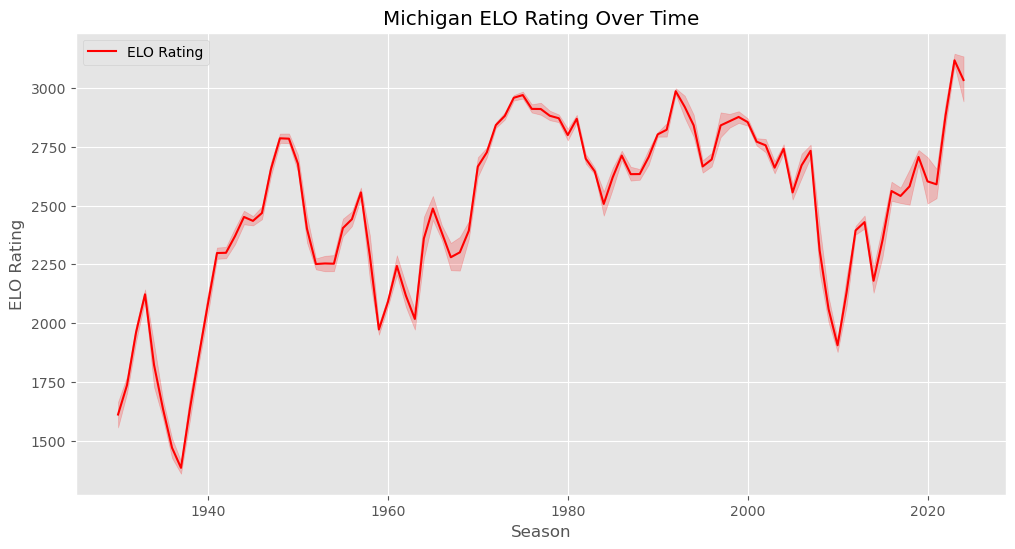

In [ ]:
team = "Michigan"

df_wisconsin = df.query("home_team == @team | away_team == @team").copy()
df_wisconsin.loc[:, 'elo'] = df_wisconsin['home_elo'].where(df_wisconsin['home_team'] == team, df_wisconsin['away_elo'])
df_wisconsin.loc[:, 'elo_post'] = df_wisconsin['home_elo_post'].where(df_wisconsin['home_team'] == team, df_wisconsin['away_elo_post'])
plt.style.use('ggplot')

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_wisconsin, x='season', y='elo_post', label='ELO Rating', color='red')
plt.title(f"{team} ELO Rating Over Time")
plt.xlabel("Season")
plt.ylabel("ELO Rating")
plt.legend()

plt.show()

In [49]:
df.head()

,season,week,home_id,home_team,home_classification,home_points,away_id,away_team,away_classification,away_points,home_result,away_result,home_elo,home_elo_post,away_elo,away_elo_post
0,1930,2,1000001,Denver,fbs,40.0,1000049,Regis (CO),fbs,0.0,1.0,0.0,1500.00000,1579.570130,1500.0,1420.429870
1,1930,3,70,Idaho,fbs,6.0,147,Montana State,fbs,7.0,0.0,1.0,1500.00000,1480.194598,1500.0,1519.805402
2,1930,3,153,North Carolina,fbs,13.0,154,Wake Forest,fbs,7.0,1.0,0.0,1500.00000,1541.694713,1500.0,1458.305287
3,1930,3,204,Oregon State,fbs,16.0,1000027,Gonzaga,fbs,6.0,1.0,0.0,1500.00000,1551.379328,1500.0,1448.620672
4,1930,3,1000049,Regis (CO),fbs,14.0,36,Colorado State,fbs,7.0,1.0,0.0,1420.42987,1470.887910,1500.0,1449.541960


In [50]:
df.query('home_id==204 or away_id==204').head()

,season,week,home_id,home_team,home_classification,home_points,away_id,away_team,away_classification,away_points,home_result,away_result,home_elo,home_elo_post,away_elo,away_elo_post
3,1930,3,204,Oregon State,fbs,16.0,1000027,Gonzaga,fbs,6.0,1.0,0.0,1500.000000,1551.379328,1500.000000,1448.620672
17,1930,4,30,USC,fbs,27.0,204,Oregon State,fbs,7.0,1.0,0.0,1613.443770,1672.120044,1551.379328,1492.703054
80,1930,6,24,Stanford,fbs,13.0,204,Oregon State,fbs,7.0,1.0,0.0,1500.000000,1541.195060,1492.703054,1451.507994
173,1930,8,204,Oregon State,fbs,7.0,265,Washington State,fbs,14.0,0.0,1.0,1451.507994,1409.677907,1689.025105,1730.855192
262,1930,10,204,Oregon State,fbs,15.0,2483,Oregon,fbs,0.0,1.0,0.0,1409.677907,1493.668739,1659.063742,1575.072910


In [51]:
df_final = (
    pd.concat([
        df[['season','week','home_id','home_team','home_classification','home_elo']]
        .rename(columns={'home_id': 'team_id', 'home_team': 'team', 'home_classification': 'division', 'home_elo': 'elo'}),
        df[['season','week','away_id','away_team','away_classification','away_elo']]
        .rename(columns={'away_id': 'team_id', 'away_team': 'team', 'away_classification': 'division', 'away_elo': 'elo'})
    ])
    .sort_values(['team_id','season','week'])
    .reset_index(drop=True)
)

In [59]:
# Directory for caching
elo_dir = join(DATA_DIR, "elo")
if not os.path.exists(elo_dir):
    os.makedirs(elo_dir)

for season in df_final.season.unique():
    df_final.query("season == @season").reset_index(drop=True).to_parquet(join(elo_dir, f"{season}.parquet"))